# Neuro4ML - Week 3 - Brain structure

This week we're going to analyse some real data, which come from larval zebrafish. 

Larval zebrafish are an increasingly used model in neuroscience for three main reasons:
1. They develop rapidly ex utero, from a single cell to a free-swimming larva in just four days, meaning that their development can be easily studied.
2. They display a variety of behaviours including a distinct locomotor repertoire, a diurnal pattern of activity and by three weeks of age, social preference.
3. They have a vertebrate brain plan and at larval stages are small (~4mm body length) and translucent, enabling cellular-resolution whole-brain imaging in both fixed tissue and live animals. 

In this notebook we're going to look at the 3d morphology of ~4,000 neurons in the zebrafish brain. In brief these morphologies were obtained by: 
* Fluorescently labeling 1-2 neurons per animal.
* Imaging each animal and tracing each neuron.
* Aligning these images in 3d so that all neurons are in a common reference frame.  

You can learn more about the data in [Kunst et al., 2019](https://doi.org/10.1016/j.neuron.2019.04.034) or on this [website](https://mapzebrain.org/home).  

There are four parts to the exercise: loading the data, looking at the data, estimating a connectivity matrix and some open exploration. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

import neurom as nm
from neurom.view.matplotlib_impl import plot_morph

def figure(): 
    fig, ax = plt.subplots(figsize=[6, 8], sharex=True, sharey=True)
    ax.set_aspect('equal')
    ax.axis("off")
    plt.gca().invert_yaxis()

    return fig, ax

### Part 0 - Loading the data 

Before getting started we need to download the data. 

How to do this depends on how you're working: 
* **Locally**: download the data [here](https://api.mapzebrain.org/media/downloads/Neurons/mapZebrain__neurons.zip), unzip the folder and provide a path to the Aligned/Original folder in the cell below - something like './mapZebrain__neurons/Aligned/Original'. 
* **Colab**: run the three commands in the cell below to fetch, unzip and provide a path to the data.

In [4]:
# Download the data 

# Locally:   
folder_path = "/Users/dorijandonajmagasic/Documents/London/Imperial/Neuroscience/Aligned/Original"  # provide a path to the Aligned/Original folder

# Colab: 
# !wget https://api.mapzebrain.org/media/downloads/Neurons/mapZebrain__neurons.zip
# !unzip /content/mapZebrain__neurons.zip 
# folder_path = "/content/Aligned/Original"

Next we need to understand the data and tools we'll be working with:
* **Data**: Each neuron's morphology is stored as an .SWC file. Try opening one in a text editor, and then understanding the format using this [guide](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).
* **Tools**: We're going to use a library called [neurom](https://neurom.readthedocs.io/en/stable/quickstart.html) to load these .SWC files.

Now we'll make a list of the neurons which we can successfully load with neurom. 

If this or later parts of the notebook run too slowly (more than a few minutes for a single cell) try working with a subset of the data by sampling from this list. 

In [7]:
# Filtering
neuron_paths = []
for file in os.listdir(folder_path): 
    neuron_path = folder_path + '/' + file
 
    try:
        m = nm.load_morphology(neuron_path) # try to load the morphology
        neuron_paths.append(neuron_path) # if this works appened the path to neuron_paths
    except: 
        pass # otherwise just skip this neuron 

print("Loaded " + str(len(neuron_paths)) + " of " + str(len(os.listdir(folder_path))) + " neurons.")

Loaded 3175 of 4327 neurons.


### Part 1 - Looking at the data 

Now we can load the morphologies, let's try plotting some neurons in 2d. For random neurons, the code below plots:
* It's morphology as a black line.
* It's points as grey circles.
* The location of it's soma as a green circle.

Note how we access these properties from the loaded morphology. 

When working with real data, especially large datasets, it's important to get a "feel" for the data, so try looking at as many neurons as possible - how similar are they?

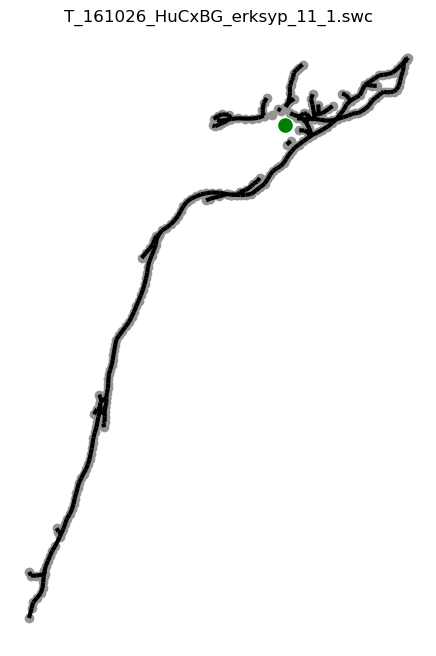

In [21]:
# Plotting single neurons in 2d 
n = np.random.randint(low=0, high=len(neuron_paths)) # sample a random neuron
m = nm.load_morphology(neuron_paths[n]) # load it's morphology

fig, ax = figure()
plot_morph(m,ax=ax, soma_outline=0, plane='xy', diameter_scale=None, linewidth=3, color='k', alpha=1.0)
plt.scatter(m.points[:,0], m.points[:,1], color='xkcd:grey')
plt.scatter(m.soma.center[0], m.soma.center[1], s=90, color='g')

Now try writing some code to plot single neurons in 3d.

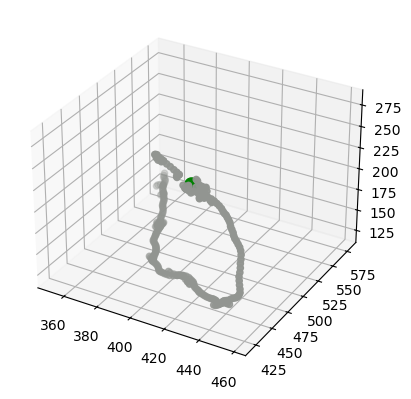

In [23]:
# Plotting single neurons in 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=m.points[:,0], ys=m.points[:,1], zs=m.points[:,2], color='xkcd:grey')
ax.scatter(xs=m.soma.center[0], ys=m.soma.center[1], zs=m.soma.center[2], s=90, color='g')

Now try to plot all of the neurons together on a single axis in either 2 or 3d. 

In general using a low alpha (transparency) value can be helpful for plots with many points.

[Figure 1E](https://doi.org/10.1016/j.neuron.2019.04.034) could provide you with some inspiration for what this plot could look like!

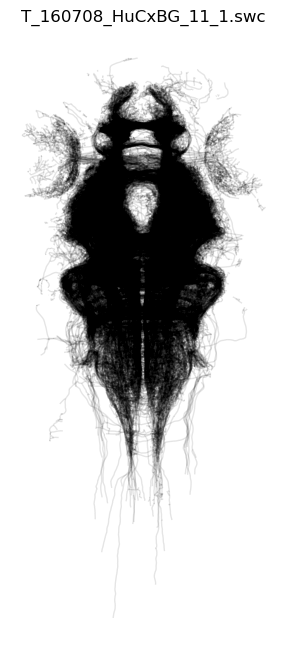

In [24]:
# Plot all of the neurons together
fig, ax = figure()
for neuron_path in neuron_paths:
    m = nm.load_morphology(neuron_path)
    plot_morph(m,ax=ax, soma_outline=0, plane='xy', diameter_scale=None, linewidth=1, color='k', alpha=0.1)

### Part 2 - Estimating a connectivity matrix 

In week 3 of the course we learnt about [connectomes](https://youtu.be/LANmSbhbdBA?si=HKDoBD7IbS3o4Uhv) - diagrams describing how every neuron connects to every other neuron in an animal. 

To create a connectome we need higher resolution data (from electron microscopy), but from the data we have we can estimate how strongly *areas* of the brain connect to each other.

Ideally we would do this by determining where each neuron's dendrites and axon were, dividing the brain into anatomical regions (optic tectum, cerebellum etc), and then working out where the dendrites in each region receive their inputs from. 

Though, as a *very rough estimate* we can:
1. Treat each neuron as having a single input and output point; respectively it's soma and the furthest point from it's soma.
2. Divide the brain into a 3d grid. 
3. Assign each neuron's input and output point to a pair of grid cells (which we'll term voxels). 

Let's work through each of these three steps.

#### Part 2.1
Write code to define the output point for a single neuron. Check that it works by plotting some single neurons in either 2 or 3d and marking their output point with a coloured circle.

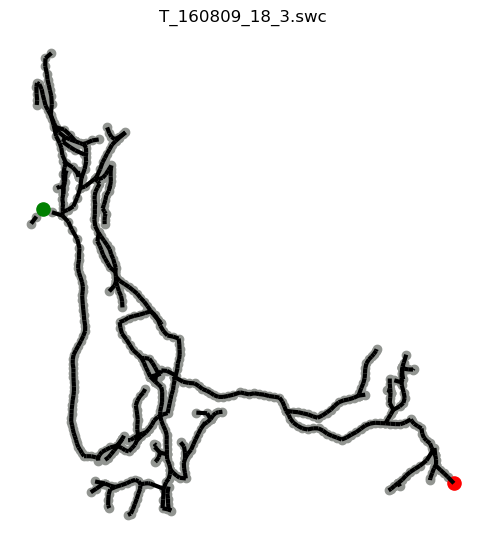

In [26]:
# Define the output point for a single neuron
n = np.random.randint(low=0, high=len(neuron_paths))
m = nm.load_morphology(neuron_paths[n])
n_out = np.argmax(np.sum((m.points[:, :3] - m.soma.center) ** 2, axis=1))

# Check that this seems to work by plotting some data
fig, ax = figure()
plot_morph(m,ax=ax, soma_outline=0, plane='xy', diameter_scale=None, linewidth=3, color='k', alpha=1.0)
plt.scatter(m.points[:,0], m.points[:,1], color='xkcd:grey')
plt.scatter(m.soma.center[0], m.soma.center[1], s=90, color='g')
plt.scatter(m.points[n_out,0], m.points[n_out,1], s=90, color='red')


Now load each neuron in turn and extract it's input (soma) and output (furthest point from soma) locations. 

Real datasets can contain small errors, and here you may find that some neuron's lack any points. 

In that case skip over those neurons as in Part 0, though make sure that you end up with an equal number of inputs and outputs by using an [assert statement](https://www.w3schools.com/python/ref_keyword_assert.asp) at the end of your code.

In [27]:
# Define each neurons input and output point
inputs, outputs = [], []
for neuron_path in neuron_paths:
    m = nm.load_morphology(neuron_path)

    try:
        n_out = np.argmax(np.sum((m.points[:, :3] - m.soma.center) ** 2, axis=1))
        inputs.append(m.soma.center)
        outputs.append(m.points[n_out, :3])
    except:
        pass

# Use an assert statement at the end of your code
assert len(inputs) == len(outputs), "The number of inputs does not match the number of outputs"
print(str(len(inputs)) + ' inputs with ' + str(len(outputs)) + ' outputs.')

3169 inputs with 3169 outputs.


Now try plotting all of the neurons (on one axis) as single lines connecting their input and output points. 

If you've done this correctly it should resemble the last figure in Part 1 surprisingly well.  

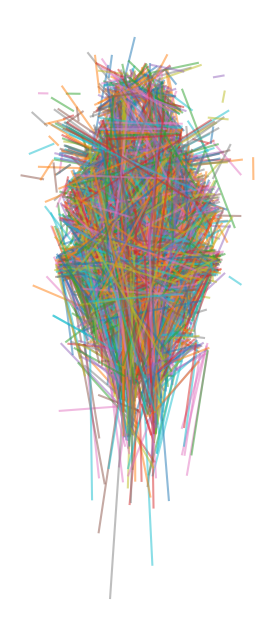

In [28]:
# Plot all of the neurons together in line form (input-output point)
# fig, ax = figure()
# Plot
n = np.random.randint(low=0, high=len(neuron_paths)+1)

figure()
plt.plot([np.array(inputs)[:,0], np.array(outputs)[:,0]],
         [np.array(inputs)[:,1], np.array(outputs)[:,1]],
         alpha=0.5

);

#### Part 2.2

Now we need to divide the brain into a 3d grid.

Too coarse a grid may be uninformative, but too fine a grid may be overly sparse.

Try to check if your grid seems reasonable by overlaying it on some whole-brain plots. 

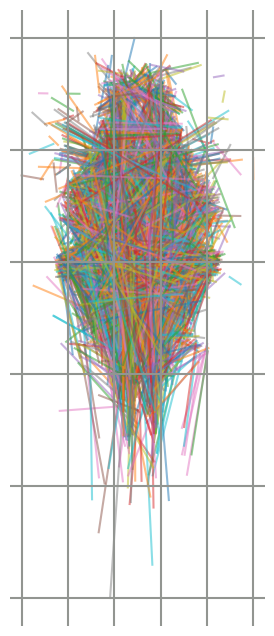

In [29]:
# Divide the brain into a 3d grid
from scipy import stats
_, binedges, output_binnumber = stats.binned_statistic_dd(sample=np.array(outputs), values=None, statistic='count', bins=5)
_, _, input_binnumber = stats.binned_statistic_dd(sample=np.array(inputs), values=None, statistic='count', bins=binedges)

# Try to check if your grid seems reasonable (with some plots)
figure()
plt.plot([np.array(inputs)[:,0], np.array(outputs)[:,0]],
         [np.array(inputs)[:,1], np.array(outputs)[:,1]],
         alpha=0.5

);

for edge in binedges[0]:
    plt.axvline(edge, color='xkcd:grey')

for edge in binedges[1]:
    plt.axhline(edge, color='xkcd:grey')

#### Part 2.3 

Finally we need to assign each neuron's input and output point to a pair of voxels. 

Create a voxel (input) x voxel (output) connectivity matrix where each cell reports the number of neuron's which connect that pair.  

Try to visualise this matrix as a heatmap. 

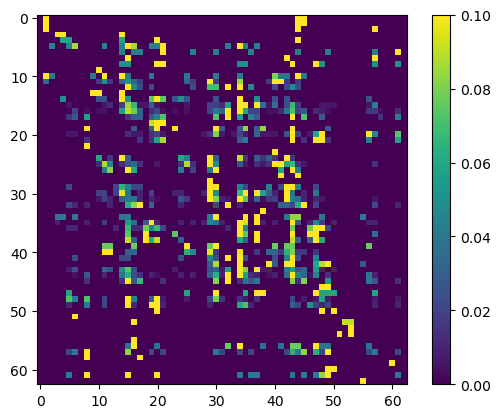

In [30]:
# Create a connectivity matrix 

# Visualise this matrix as a heatmap 
connectivity = np.zeros((max(input_binnumber)+1, max(input_binnumber)+1))
for i, o in zip(input_binnumber, output_binnumber):
    connectivity[i,o] += 1

mask = np.any(connectivity, axis=1)
connectivity_masked = connectivity[mask][:, mask]
connectivity_masked_norm = connectivity_masked / np.sum(connectivity_masked, axis=1)[:, None]
plt.imshow(connectivity_masked_norm, vmin=0., vmax=.1)
plt.colorbar()

### Part 3 - Open exploration 

Now that you know how to work with this data, you should try to explore something that interests you!

Here are a few ideas to get you started:
* **Improving our approach** - as we highlighted above, our connectivity matrix is at best a very rough estimate as we reduce neurons to lines and brain regions to cells in an arbitrary grid. How could you improve on this? The original [paper](https://doi.org/10.1016/j.neuron.2019.04.034) may provide some ideas.    
* **Bilateral symmetry** - in biology many structures are symmetrical across the midline. How similar are the left and right sides of the larval zebrafish brain? Are there any areas which are asymmetrical in their connectivity?    
* **Information flow** - this [paper](https://www.science.org/doi/10.1126/science.add9330#sec-4) uses a signal cascade algorithm to estimate how information flows through the *Drosophila* larva connectome. Try implementing their approach and see if you can discover any patterns in how signals flow through the larval zebrafish brain.    
